In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import itertools
import json

In [11]:
import sys
import os.path
import pandas as pd
# Local Modules
sys.path.insert(0, os.path.abspath('/scratch/horta/coronatwitter/'))
from helpers.vars import categories_coarse, types, langs, lang_names, lang_colors,\
                         nicer_words, remove_not_in_english, quint, categories_final
from helpers.plot import set_size
from helpers.df import get_avg

In [28]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

fontpath = os.path.expanduser('/dlabdata1/Roboto-Thin.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",#prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [13]:
df = pd.read_parquet(path + "merged_predictions")
df.dropna(subset=["userbio_lang"], inplace=True)
df = df.loc[df.userbio_lang.apply(lambda x:  x in ['en', 'ja', 'es', 'pt', 'ar', 'fr', 'de', 'it']), 
            ["user.id", "type_label", "category_label", "userbio_lang"]]

In [14]:
mapping_to_categories_coarse = {
    'art': 'Art',
    'business': 'Business',
    'politics': 'Government and Politics',
    'healthcare': 'Healthcare',
    'media': 'Media',
    'ngo': 'Non-Governmental Organization',
    'political_supporter': 'Outspoken Political Supporter',
    'porn': 'Porn',
    'public_services': 'Public Services',
    'religion': 'Religion',
    'science': 'Science',
    'sports': 'Sport',
    'other': 'Other'
}

df["category_label"] = df.category_label.apply(lambda x: mapping_to_categories_coarse[x])

In [15]:
for category in categories_coarse:
    df[category + "_avg"] = df.category_label == category

In [16]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(df["user.id"].values)
for c in [c + "_avg" for c in categories_coarse]:
    print(c)
    tmp = df.set_index("user.id")[c].astype(int).to_dict()
    nx.set_node_attributes(G, tmp, name=c)
nx.write_graphml(G, path=path + "graph_rts.graphml")

Art_avg
Business_avg
Government and Politics_avg
Healthcare_avg
Media_avg
Non-Governmental Organization_avg
Outspoken Political Supporter_avg
Porn_avg
Public Services_avg
Religion_avg
Science_avg
Sport_avg
Other_avg


In [17]:
df2 = pd.read_pickle(path + "/datasets/covid_stream_7_days_all_tweets_10_rt.pickle")
dict_tweet_userid = dict(df2.set_index("id")["user.id"])

In [18]:
path = "/dlabdata1/gligoric/Coronatwitter/"
f = path + 'retweet_user_dump.jsonl'
fl = open(f, "r")

df_list = []

idx = 0
for l in fl:
    idx += 1
    if idx % 10000 == 0:
        print(idx, len(G.edges))
    lj = json.loads(l)
    key = list(lj.keys())[0]
    try:
        user_id_retweeted = dict_tweet_userid[key]
    except:
        continue
    if G.has_node(user_id_retweeted):
        for rt in lj[key]:
            if rt["user.id"] == user_id_retweeted:
                continue
            if G.has_node(rt["user.id"]):
                G.add_edge(rt["user.id"], user_id_retweeted)
        
nx.write_graphml(G, path=path + "graph_rts2.graphml")

10000 138492
20000 231877
30000 331244
40000 441747
50000 541196
60000 633053
70000 732637
80000 820255


In [19]:
edges = np.array(list(G.edges))
N = len(list(G.edges))
idx = np.array(np.arange(N))

In [20]:
cat_edge = {}
for edge in G.edges():
    src = [cat for cat, val in G.nodes[edge[0]].items() if val > 0][0]
    dst = [cat for cat, val in G.nodes[edge[1]].items() if val > 0][0]
    cat_edge[edge] = (src.replace("_avg", ""), dst.replace("_avg", ""))
nx.set_edge_attributes(G, cat_edge, name="edget")

In [22]:
from collections import Counter

df_adj_cs = []
iter_b = 100
count = 0
for i in range(iter_b):
    if i % 1 == 0:        
        print(i)
    c = np.random.choice(idx, size=N, replace=True)
    df_adj_c = pd.DataFrame(0, index=categories_coarse, columns=categories_coarse)
    
    edges_cats = [cat_edge[(src, dst)] for src, dst in edges[c]]
    for (src, dst), val in Counter(edges_cats).items():
        df_adj_c.loc[src, dst] += val

    df_adj_cs.append(df_adj_c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [23]:
categories_sorted = ['Government and Politics',
 'Healthcare',
 'Public Services',
 'Non-Governmental Organization',
 'Media',
 'Science',
 'Outspoken Political Supporter',
 'Business',
 'Art',
 'Religion',
 'Sport',
 'Porn']

Government and Politics
dst: Government and Politics src: Porn
0.001320479124909615 0.0012534078767493396 0.001409387523633702
0.00043399200229847425 0.0003143171460003143 0.0005862335211187052
-0.0008864871226111411 -0.001027638988040553 -0.0007550565775950953
dst: Government and Politics src: Sport
0.009743201794211594 0.009578264459034732 0.009916963120840776
0.011026112056029116 0.010384911251032794 0.011841881070028966
0.0012829102618175192 0.0006049873913832795 0.0019895380886117125
dst: Government and Politics src: Religion
0.005201497850266223 0.005062653681732443 0.005361243291482509
0.00600095681770648 0.0055728429985855725 0.006506364922206506
0.0007994589674402562 0.0002675573696871566 0.0013330637878438195
dst: Government and Politics src: Art
0.0366095818297081 0.03626861032161889 0.0370106277846545
0.034712414112436106 0.03332386363636364 0.03594506696206667
-0.0018971677172720041 -0.003060010500703883 -0.0007006586422527369
dst: Government and Politics src: Business
0.0

dst: Non-Governmental Organization src: Porn
0.001320479124909615 0.0012534078767493396 0.001409387523633702
0.001127291301843469 0.00038337678270203957 0.0017613723387961402
-0.00019318782306614632 -0.0008789442167264066 0.000421194423455863
dst: Non-Governmental Organization src: Sport
0.009743201794211594 0.00957826445903473 0.009916963120840776
0.009391105491391164 0.007983576642335767 0.010930232558139534
-0.0003520963028204316 -0.001770668348237107 0.0013341351076855794
dst: Non-Governmental Organization src: Religion
0.005201497850266223 0.005062653681732443 0.005361243291482508
0.00622626956182968 0.004793061472915399 0.007564180929095355
0.0010247717115634569 -0.0003884349809734006 0.002338349731811902
dst: Non-Governmental Organization src: Art
0.03660958182970811 0.03626861032161889 0.0370106277846545
0.03747221377789361 0.034182770036184466 0.040366272415108734
0.0008626319481854964 -0.0023857256747641803 0.0036208100301576493
dst: Non-Governmental Organization src: Busines

dst: Outspoken Political Supporter src: Porn
0.001320479124909615 0.0012534078767493396 0.0014093875236337017
0.0003341485418760573 0.0002028809089064719 0.00047657952069716776
-0.0009863305830335582 -0.0011626422678442099 -0.0008251234398302335
dst: Outspoken Political Supporter src: Sport
0.009743201794211594 0.009578264459034732 0.009916963120840776
0.007114900131308926 0.006082039961255153 0.00783106624719915
-0.0026283016629026702 -0.0035854906497152584 -0.0018474494919214048
dst: Outspoken Political Supporter src: Religion
0.005201497850266223 0.005062653681732443 0.005361243291482508
0.007567991078865867 0.006849160243224304 0.008618550188389775
0.0023664932285996426 0.0016608146110406652 0.003442254192498725
dst: Outspoken Political Supporter src: Art
0.0366095818297081 0.03626861032161889 0.0370106277846545
0.03716478880014959 0.035702203477750966 0.0388724504777178
0.0005552069704414845 -0.0010119511631437803 0.002107832485902711
dst: Outspoken Political Supporter src: Busine

dst: Religion src: Porn
0.001320479124909615 0.0012534078767493396 0.0014093875236337017
0.0 0.0 0.0
-0.0013204791249096157 -0.0014093875236337017 -0.0012534078767493396
dst: Religion src: Sport
0.009743201794211594 0.009578264459034732 0.009916963120840774
0.008849868168812263 0.0038314176245210726 0.016016016016016016
-0.0008933336253993331 -0.00590516639295795 0.006154759911919655
dst: Religion src: Religion
0.005201497850266223 0.005062653681732444 0.005361243291482508
0.09483822031977251 0.07758620689655173 0.11578947368421053
0.08963672246950626 0.07247341689974932 0.1105920090219566
dst: Religion src: Art
0.03660958182970811 0.03626861032161889 0.037010627784654505
0.03536211956437151 0.02261553588987217 0.04827586206896552
-0.001247462265336597 -0.01408536088168338 0.011868957773765357
dst: Religion src: Business
0.018382758455489537 0.01808249763523714 0.018631768820337073
0.018537289872524596 0.011396011396011397 0.027695351137487636
0.00015453141703506153 -0.0071154302681577

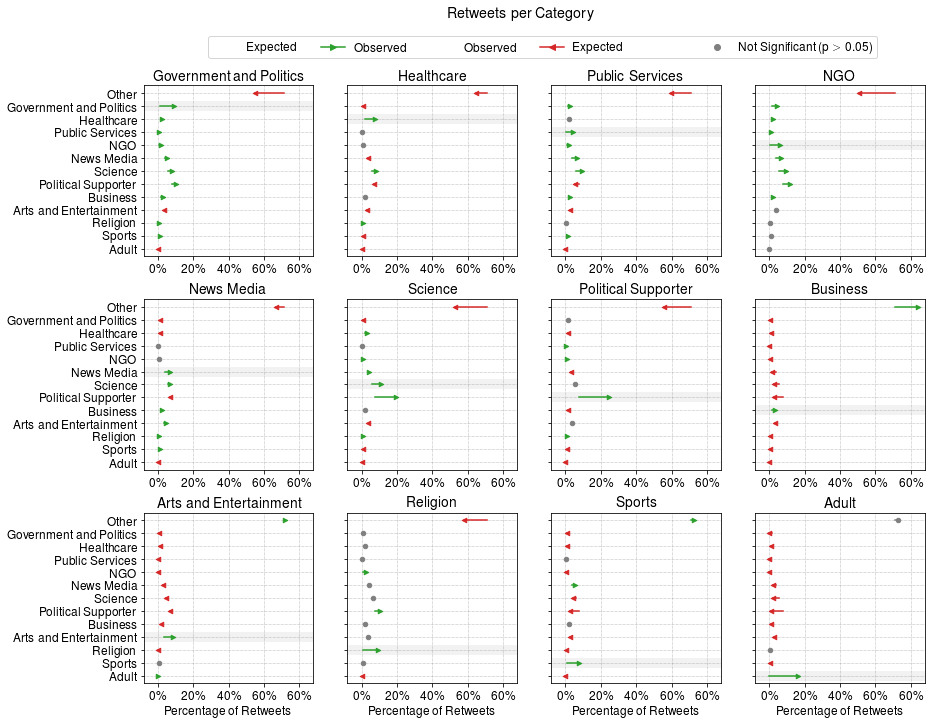

In [29]:
def get_val(cat, index, arrs, iter_b):
    idx = index.index(cat)
    vals = np.stack(arrs)[:, idx]
    vals = sorted(vals)
    low = vals[int(0.025 * iter_b)]
    high = vals[int(0.975 * iter_b)]
    mean = np.mean(vals)
    return mean, low, high
    
def get_val_diff(cat, index, arrs_o, arrs_e, iter_b):
    idx = index.index(cat)
    vals_o = np.stack(arrs_o)[:, idx]
    vals_e = np.stack(arrs_e)[:, idx]
    vals = sorted(vals_o - vals_e)
    low = vals[int(0.025 * iter_b)]
    high = vals[int(0.975 * iter_b)]
    mean = np.mean(vals)
    return mean, low, high
    
def get_incoming(df_adj_c, cat):
#     df_adj_c_ = df_adj_c.drop("Other", axis=0).drop("Other", axis=1)
    df_adj_c_ = df_adj_c#.drop("Other", axis=0).drop("Other", axis=1)
    bar = df_adj_c_[cat] / df_adj_c_[cat].sum()
    B = df_adj_c_.sum().sum()
    vals = df_adj_c_.sum(axis=0).values.reshape(1, -1) * df_adj_c_.sum(axis=1).values.reshape(-1, 1) / B
    df_adj_c_expected = pd.DataFrame(vals, index=categories_coarse, columns=categories_coarse)
    bar_e = df_adj_c_expected[cat] / df_adj_c_expected[cat].sum()
    return list(bar.index), bar.values, bar_e.values

fig, axs_all = plt.subplots(3,4, figsize=(14,11), sharex=False, sharey=True, gridspec_kw={"hspace": 0.25})
axs_all = axs_all.flatten()



for ax, dest in zip(axs_all, categories_sorted):
    print(dest)
    arrs_o, arrs_e = [], []
    for df_adj_c in df_adj_cs:
        index, arr_o, arr_e = get_incoming(df_adj_c, cat=dest)
        arrs_o.append(arr_o)
        arrs_e.append(arr_e)
        
    cats_to_it = index[:-1]
#     cats_to_it.remove("Porn")
#     cats_to_it.remove("Religion")
    
    for idx, cat in enumerate(categories_sorted[::-1] + ["Other"]):
        mean_e, low_e, high_e = get_val(cat, index, arrs_e, iter_b)
        mean_o, low_o, high_o = get_val(cat, index, arrs_o, iter_b)
        mean_d, low_d, high_d = get_val_diff(cat, index, arrs_o, arrs_e, iter_b)
        
        print("dst:", dest, "src:", cat)
        print(mean_e, low_e, high_e)
        print(mean_o, low_o, high_o)
        print(mean_d, low_d, high_d)
        
        if cat == dest:
            ax.axhline(idx, lw=10, alpha=0.05, color="black", zorder=1)
        
        # not sign:
        if mean_o >= mean_e:
            color = "tab:green"
            marker = ">"
        else:
            color = "tab:red"
            marker = "<"
        
        if low_d < 0 and high_d > 0:
            color = "tab:gray"
            marker = "o"
            
        ax.plot([mean_e, mean_o], [idx, idx], color=color, lw=1.5, zorder=3)
        ax.scatter([mean_o], [idx], s=20, color=color, marker=marker, zorder=3)

    ax.set_yticks(range(idx+1))
    ax.set_yticklabels([categories_final[c] for c in categories_sorted[::-1]  + ["Other"]])
    ax.set_xticks([0, 0.20, 0.40, 0.60, .80])
    ax.set_xticklabels([r'0\%', r'20\%', r'40\%', r'60\%', r'60\%'])
    ax.set_xlim([-0.08, 0.88])

    ax.set_title(categories_final[dest])
    ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    if dest in ['Art', 'Religion', 'Sport', 'Porn']:
        ax.set_xlabel("Percentage of Retweets")


#     ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0, is_latex=True))
idx += 1

from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color="tab:green", lw=0),
    Line2D([0], [0], color="tab:green", lw=1.5, marker=">"),
    Line2D([0], [0], color="tab:red", lw=0),
    Line2D([0], [0], color="tab:red", lw=1.5, marker="<"),
    Line2D([0], [0], color="tab:red", lw=0),
    Line2D([0], [0], color="tab:gray", lw=0, marker="o"),

]

axs_all[1].legend(
    custom_lines, 
    ['Expected', 'Observed', "Observed", "Expected", "", "Not Significant (p $>$ 0.05)"],
    loc='upper center', 
    bbox_to_anchor=(1.15,1.325),
    ncol = 6
)

fig.suptitle("Retweets per Category")


# set_size(fig, (14, 11))
fig.savefig("../images/4B_who_r_who.pdf", bbox_inches="tight")